In [28]:
import os
import sys
# sys.path.insert(0,'/code/')

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
import torchvision.transforms as T
from torchvision.datasets import ImageNet, CIFAR100, CIFAR10, STL10, ImageFolder
import pandas as pd
from torchvision.utils import save_image

import multiprocessing as mp
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score

from datasets.dataset import ImageToHash_Attack

from datasets.imagenette import ImageNette
from metrics.hamming_distance import hamming_distance
from adv3_robustness_check import get_rotation_angles, get_translation_tuples
from utils.transforms import Rotate, Translate, ChangeSaturation, ChangeHue, ChangeContrast, ChangeBrightness, \
    JpegCompression, HorizontalFlipping, BlackBorder, CenterCrop, VerticalFlipping
from scipy.interpolate import griddata

sns.set_style("ticks", {'axes.grid': True})

In [37]:
DATASET = 'coco_val'
TARGET = 'photodna_nn'
PLOT_DIR = f'robustness_by_metrics_plots/{DATASET}_{TARGET}'
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)
MAX_ROT_ANGLE = 64
ROT_LOG_BASE = 2
ROT_STEPS = 7
MAX_TRANS = 64
TRANS_LOG_BASE = 2
TRANS_STEPS = 7

HASH_DIR = f'logs/{DATASET}_{TARGET}'

In [43]:
def l1_distance(tensor1, tensor2):
    loss = torch.nn.L1Loss(reduction='sum')
    l1 = []
    for i in range(tensor1.shape[0]):
        l1.append(loss(tensor1[i],tensor2[i]).item())
    return l1

def l1_distance_pairwise(tensor1, tensor2, batch_size=200, use_gpu=True):
    if use_gpu:
        tensor1, tensor2 = tensor1.cuda(), tensor2.cuda()

    num_items_1 = tensor1.size(0)
    num_items_2 = tensor2.size(0)
    l1_matrix = torch.zeros((num_items_1, num_items_2), device='cuda' if use_gpu else 'cpu')

    # Process in batches
    for i in range(0, num_items_1, batch_size):
        end_i = i + batch_size
        tensor1_batch = tensor1[i:end_i]

        for j in range(0, num_items_2, batch_size):
            end_j = j + batch_size
            tensor2_batch = tensor2[j:end_j]

            # Expand and compute distances
            tensor1_expanded = tensor1_batch.unsqueeze(1)
            tensor2_expanded = tensor2_batch.unsqueeze(0)
            diff = torch.abs(tensor1_expanded - tensor2_expanded)
            l1_distances_batch = diff.sum(2)

            # Assign computed distances to the appropriate submatrix
            l1_matrix[i:end_i, j:end_j] = l1_distances_batch

    return l1_matrix.cpu()


# def calculate_metrics(l1_matrix, threshold=1800, batch_size=200):
#     l1_matrix = torch.tensor(l1_matrix, device='cuda')  # Move the matrix to GPU
#     n = l1_matrix.size(0)
# 
#     tp = torch.tensor(0, device='cuda')
#     fp = torch.tensor(0, device='cuda')
#     fn = torch.tensor(0, device='cuda')
#     tn = torch.tensor(0, device='cuda')
# 
#     # Process the full matrix in batches
#     for i in range(0, n, batch_size):
#         end_i = min(i + batch_size, n)
#         # Extract a batch from the matrix
#         batch = l1_matrix[i:end_i, i:end_i]
#         # Create a mask for elements that should match (diagonal elements of each submatrix)
#         should_match = torch.eye(batch.size(0), device='cuda', dtype=torch.bool)
#         is_match = (batch <= threshold)
# 
#         # Calculate TP, FP, FN, TN using logical operations
# 
#         tp += torch.logical_and(is_match, should_match).sum()
#         tn += torch.logical_and(~is_match, ~should_match).sum()
#         fp += torch.logical_and(is_match, ~should_match).sum()
#         fn += torch.logical_and(~is_match, should_match).sum()
# 
#     # Since the l(i,j) = l(j,i), so the fp and tn are doubled
#     fp = fp/2
#     tn = tn/2     
#     precision = tp.float() / (tp + fp) if tp + fp > 0 else torch.tensor(0.)
#     recall = tp.float() / (tp + fn) if tp + fn > 0 else torch.tensor(0.)
#     f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else torch.tensor(0.)
# 
# 
#     print("Precision:", precision.item())
#     print("Recall:", recall.item())
#     print("F1 Score:", f1.item())
# 
#     return precision.item(), recall.item(), f1.item()


def calculate_metrics(l1_matrix, threshold=1800, batch_size=200, steepness=0.01):
    l1_matrix = torch.tensor(l1_matrix, device='cuda')  # Move the matrix to GPU
    n = l1_matrix.size(0)

    tp = torch.tensor(0.0, device='cuda')
    fp = torch.tensor(0.0, device='cuda')
    fn = torch.tensor(0.0, device='cuda')
    tn = torch.tensor(0.0, device='cuda')

    # Process the full matrix in batches
    for i in range(0, n, batch_size):
        end_i = min(i + batch_size, n)
        batch = l1_matrix[i:end_i, i:end_i]
        should_match = torch.eye(batch.size(0), device='cuda', dtype=torch.bool)

        # Convert distances to probabilities
        probabilities = 1 / (1 + torch.exp(-steepness * (threshold - batch)))

        # Define matches based on probability threshold of 0.5
        is_match = probabilities >= 0.5

        # Calculate TP, FP, FN, TN using logical operations
        tp += (torch.logical_and(is_match, should_match) * probabilities).sum()
        tn += (torch.logical_and(~is_match, ~should_match) * (1 - probabilities)).sum()
        fp += (torch.logical_and(is_match, ~should_match) * probabilities).sum()
        fn += (torch.logical_and(~is_match, should_match) * (1 - probabilities)).sum()
    

    # Adjust for symmetric matrix specifics
    fp = fp / 2
    tn = tn / 2

    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp) if tp + fp > 0 else torch.tensor(0., device='cuda')
    recall = tp / (tp + fn) if tp + fn > 0 else torch.tensor(0., device='cuda')
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else torch.tensor(0., device='cuda')

    print("Precision:", precision.item())
    print("Recall:", recall.item())
    print("F1 Score:", f1.item())

    return f1.item(), precision.item(), recall.item()

def calculate_roc_auc(l1_matrix, threshold_range = (1800, 4000), num_thresholds=100, steepness=0.01, batch_size=200):
    l1_matrix = torch.tensor(l1_matrix, device='cuda')  # Move the matrix to GPU
    n = l1_matrix.size(0)

    # Initialize storage for all probabilities and labels
    all_probabilities = []
    all_labels = []

    # Process the full matrix in batches
    for i in range(0, n, batch_size):
        end_i = min(i + batch_size, n)
        batch = l1_matrix[i:end_i, i:end_i]
        should_match = torch.eye(batch.size(0), device='cuda', dtype=torch.bool)

        # Process each threshold
        thresholds = np.linspace(threshold_range[0], threshold_range[1], num=num_thresholds)
        for threshold in thresholds:
            # Convert distances to probabilities
            probabilities = 1 / (1 + torch.exp(-steepness * (threshold - batch)))

            # Store probabilities and labels
            all_probabilities.append(probabilities.flatten())
            all_labels.append(should_match.flatten())

    # Concatenate results
    all_probabilities = torch.cat(all_probabilities).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()
    

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
    roc_auc = auc(fpr, tpr)
    # print("ROC_AUC:", roc_auc)

    return fpr, tpr, thresholds, roc_auc

def get_hashes_from_csv(file_path):
    df = pd.read_csv(file_path)
    df['hash_bin'] = df['hash_bin'].apply(lambda x: x.strip('[]').split() if 'nn' in TARGET else x.split())
    df['hash_bin'] = df['hash_bin'].apply(lambda x: [int(i) for i in x])
    bin_hashes = np.array(df['hash_bin'].tolist()).astype(int)
    
    return bin_hashes

def plot_corr_mat(df, min_corr_val=None, max_corr_val=None):
    corr_mat = df.corr()
    corr_values = np.sort(np.unique(corr_mat.values.flatten()))[:-1]
    print(f'Min Corr. Value: {corr_values.min()}')
    print(f'Max Corr. Value: {corr_values.max()}')
    sns.heatmap(
        corr_mat,
        cmap=sns.diverging_palette(250, 15, as_cmap=True),
        vmax=max_corr_val if max_corr_val else corr_values.max(),
        center=0,
        vmin=min_corr_val if min_corr_val else corr_values.min()
    )
    plt.show()


def get_augmented_hashes_and_l1_dist(filenames, augment_values, original_hashes, return_bin_hashes=False, num_processes=2, pairwise = True):
    return_hash_dict = {}
    return_l1_dict = {}

    # with tqdm(total=len(filenames)) as pbar:
    with mp.Pool(num_processes) as pool:
        for i, bin_hashes in tqdm(enumerate(pool.imap(get_hashes_from_csv, filenames))):
            return_hash_dict[augment_values[i]] = bin_hashes
            if pairwise == False:
                # Only calculate the l1 between same index
                return_l1_dict[augment_values[i]] = np.array(l1_distance(torch.tensor(bin_hashes), original_hashes))
            else:
                return_l1_dict[augment_values[i]] = np.array(l1_distance_pairwise(torch.tensor(bin_hashes), original_hashes))


    if return_bin_hashes:
        return return_hash_dict, return_l1_dict

    return return_l1_dict


def print_mean_and_std_for_keys(given_dict):
    for key in given_dict.keys():
        print(f'Mean L1 Distance for {key}: {given_dict[key].mean()}')
        print(f'Standard Deviation L1 Distance for {key}: {given_dict[key].std()}')
        


In [33]:
bin_hashes_orig = torch.tensor(get_hashes_from_csv(os.path.join(HASH_DIR, f'{DATASET}_original.csv')))

# L_inf Robustness

In [890]:
epsilons = [0.0039, 0.0078, 0.0156, 0.0312]
linf_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'linf_epsilon', f'{DATASET}_linf_epsilon_{epsilon}.csv') for epsilon in epsilons],
    epsilons,
    bin_hashes_orig,
    num_processes=4,
    pairwise=True
)

0it [00:00, ?it/s]

Precision: 0.9010125398635864
Recall: 1.0
F1 Score: 0.9479290843009949
Precision: 0.9018003940582275
Recall: 1.0
F1 Score: 0.9483649134635925
Precision: 0.9031935930252075
Recall: 1.0
F1 Score: 0.9491347670555115
Precision: 0.9069076776504517
Recall: 1.0
F1 Score: 0.9511815309524536


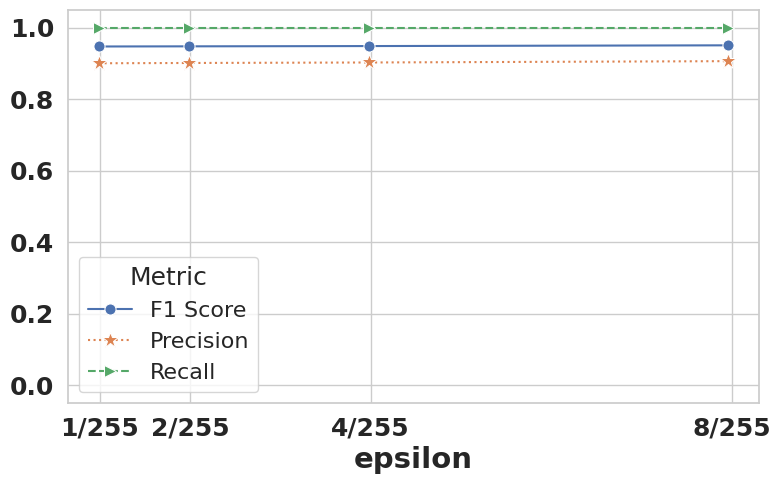

In [891]:
Trans = 'epsilon'

data = {
    Trans: [],
    'F1 Score': [],
    'Precision': [],
    'Recall': []
}
for key, values in linf_hamming.items():
    f1, precision, recall = calculate_metrics(values)
    data[Trans].append(key)
    data['F1 Score'].append(f1)
    data['Precision'].append(precision)
    data['Recall'].append(recall)
df = pd.DataFrame(data)
df.sort_values(Trans, inplace=True)


sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")


fig = sns.lineplot(x=Trans, y='F1 Score', markersize=8, data=df, marker='o', label='F1 Score')
sns.lineplot(x=Trans, y='Precision', markersize=12, data=df, marker='*', label='Precision', linestyle=':')
sns.lineplot(x=Trans, y='Recall', markersize=8, data=df, marker='>', label='Recall', linestyle='--')

fig.set_xlabel(Trans, fontsize = 21, fontweight='bold')
fig.set_ylabel('')  # Set y-axis label as none
plt.xticks([1/255, 2/255, 4/255, 8/255])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylim(-0.05, 1.05)
fig.set_xticklabels(['1/255', '2/255', '4/255', '8/255'], size = 18, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
plt.legend(title='Metric', title_fontsize='18', fontsize='16')
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf')

# Rotation Robustness

In [39]:
# get the rotation angles
angles = get_rotation_angles(MAX_ROT_ANGLE, ROT_LOG_BASE, ROT_STEPS)

In [40]:
rot_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'rotation', f'{DATASET}_rotation_{angle}.csv') for angle in angles],
    angles,
    bin_hashes_orig,
    num_processes=15,
    pairwise=True
)

0it [00:00, ?it/s]

In [42]:
for angle, values in rot_hamming.items():
    _, _, _, roc_auc = calculate_roc_auc(values)
    print(f"{'Angle':<10}{'ROC AUC':<10}")
    print(f"{angle:<10}{roc_auc:<10.4f}")

ROC_AUC: 0.5931378680914925
Angle     ROC AUC   
-64       0.5931    


KeyboardInterrupt: 

Precision: 0.051531318575143814
Recall: 0.0005914521170780063
F1 Score: 0.0011694814311340451
ROC_AUC: 0.6396986021115905
Precision: 0.7748831510543823
Recall: 0.001655887346714735
F1 Score: 0.0033047127071768045
ROC_AUC: 0.7605256863409698
Precision: 0.916680634021759
Recall: 0.02973795495927334
F1 Score: 0.05760708078742027
ROC_AUC: 0.8267224680868568
Precision: 0.9857074618339539
Recall: 0.09801153093576431
F1 Score: 0.17829473316669464
ROC_AUC: 0.8646792359908668
Precision: 0.9191797971725464
Recall: 0.99642014503479
F1 Score: 0.9562427401542664
ROC_AUC: 0.9941536709169071
Precision: 0.9069718718528748
Recall: 0.9995521903038025
F1 Score: 0.9510142207145691
ROC_AUC: 0.9971586125406885
Precision: 0.9008277058601379
Recall: 1.0
F1 Score: 0.9478268027305603
ROC_AUC: 0.9979582304408442
Precision: 0.9001225829124451
Recall: 1.0
F1 Score: 0.9474362730979919
ROC_AUC: 0.9979776039266709
Precision: 0.9015440940856934
Recall: 1.0
F1 Score: 0.9482231736183167
ROC_AUC: 0.997947098063314
Precis

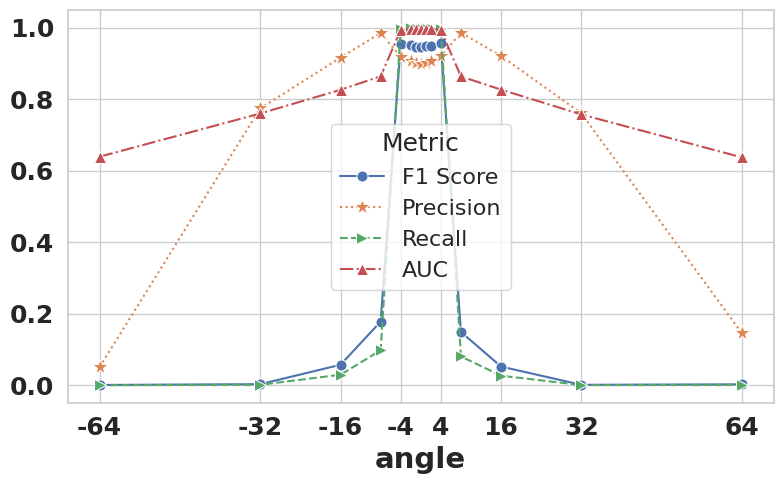

In [36]:
Trans = 'angle'

data = {
    Trans: [],
    'F1 Score': [],
    'Precision': [],
    'Recall': []
    # 'AUC': []
}
for key, values in rot_hamming.items():
    f1, precision, recall = calculate_metrics(values)
    _, _, _, roc_auc = calculate_roc_auc(values)
    data[Trans].append(key)
    data['F1 Score'].append(f1)
    data['Precision'].append(precision)
    data['Recall'].append(recall)
    # data['AUC'].append(roc_auc)
df = pd.DataFrame(data)
df.sort_values(Trans, inplace=True)


sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")

fig = sns.lineplot(x=Trans, y='F1 Score', markersize=8, data=df, marker='o', label='F1 Score')
sns.lineplot(x=Trans, y='Precision', markersize=12, data=df, marker='*', label='Precision', linestyle=':')
sns.lineplot(x=Trans, y='Recall', markersize=8, data=df, marker='>', label='Recall', linestyle='--')
# sns.lineplot(x=Trans, y='AUC', markersize=8, data=df, marker='^', label='AUC',linestyle='-.')

fig.set_xlabel(Trans, fontsize = 21, fontweight='bold')
fig.set_ylabel('')  # Set y-axis label as none
plt.xticks([-64, -32, -16,-4, 4, 16, 32, 64])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylim(-0.05, 1.05)
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
plt.legend(title='Metric', title_fontsize='18', fontsize='16')
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf')

# Hue Robustness

In [895]:
hues = list(range(-180, 180, 30))
hue_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'hue', f'{DATASET}_hue_{hue}.csv') for hue in hues],
    hues,
    bin_hashes_orig,
    num_processes=12,
    pairwise=True
)

0it [00:00, ?it/s]

Precision: 0.9067537784576416
Recall: 0.9922856092453003
F1 Score: 0.9475935101509094
Precision: 0.9085452556610107
Recall: 0.9915771484375
F1 Score: 0.9482470750808716
Precision: 0.9025673866271973
Recall: 0.9973505735397339
F1 Score: 0.9475947022438049
Precision: 0.8988872766494751
Recall: 0.9980438947677612
F1 Score: 0.9458739757537842
Precision: 0.8998738527297974
Recall: 0.9984182715415955
F1 Score: 0.9465882778167725
Precision: 0.8993328809738159
Recall: 0.9997731447219849
F1 Score: 0.9468969702720642
Precision: 0.9001445174217224
Recall: 1.0
F1 Score: 0.9474484324455261
Precision: 0.9021843671798706
Recall: 0.9993551969528198
F1 Score: 0.9482870101928711
Precision: 0.903325617313385
Recall: 0.9977916479110718
F1 Score: 0.9482116103172302
Precision: 0.905142605304718
Recall: 0.9966608285903931
F1 Score: 0.9486996531486511
Precision: 0.9048715233802795
Recall: 0.9981303215026855
F1 Score: 0.949215829372406
Precision: 0.9056065678596497
Recall: 0.9955779910087585
F1 Score: 0.948463

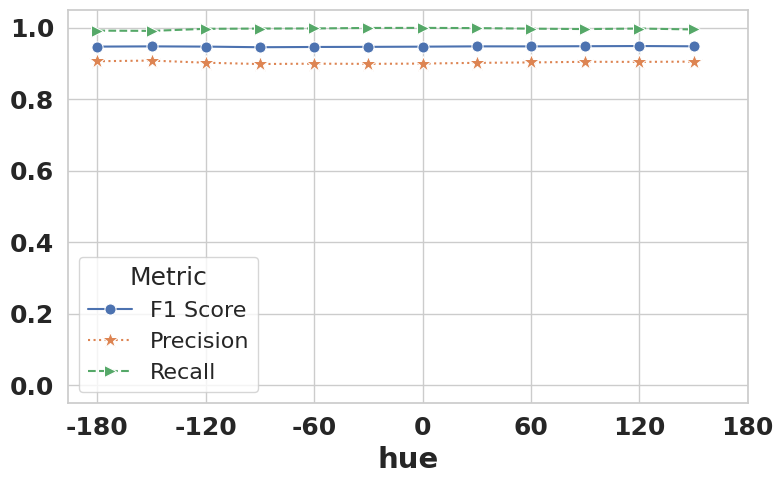

In [896]:
# # hue_hamming[180] = hue_hamming[-180]
# for hue, values in hue_hamming.items():
#     print('===> Hue:', hue)
#     calculate_metrics(values)
    
Trans = 'hue'

data = {
    Trans: [],
    'F1 Score': [],
    'Precision': [],
    'Recall': []
}
for key, values in hue_hamming.items():
    f1, precision, recall = calculate_metrics(values)
    data[Trans].append(key)
    data['F1 Score'].append(f1)
    data['Precision'].append(precision)
    data['Recall'].append(recall)
df = pd.DataFrame(data)
df.sort_values(Trans, inplace=True)


sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")

fig = sns.lineplot(x=Trans, y='F1 Score', markersize=8, data=df, marker='o', label='F1 Score')
sns.lineplot(x=Trans, y='Precision', markersize=12, data=df, marker='*', label='Precision', linestyle=':')
sns.lineplot(x=Trans, y='Recall', markersize=8, data=df, marker='>', label='Recall', linestyle='--')

fig.set_xlabel(Trans, fontsize = 21, fontweight='bold')
fig.set_ylabel('')  # Set y-axis label as none
plt.xticks([-180, -120, -60, 0, 60, 120, 180])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylim(-0.05, 1.05)
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
plt.legend(title='Metric', title_fontsize='18', fontsize='16')
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf')

# Brightness Robustness

In [897]:
brightness_values = list(np.linspace(0, 2, 9, endpoint=True))
brightness_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'brightness', f'{DATASET}_brightness_{int(brightness)}.csv' if 'nn' not in TARGET else f'{DATASET}_brightness_{brightness}.csv') for brightness in brightness_values],
    brightness_values,
    bin_hashes_orig,
    num_processes=9,
    pairwise=True
)

0it [00:00, ?it/s]

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Precision: 0.9001703858375549
Recall: 1.0
F1 Score: 0.9474628567695618
Precision: 0.900105357170105
Recall: 1.0
F1 Score: 0.9474267959594727
Precision: 0.9001415967941284
Recall: 1.0
F1 Score: 0.947446882724762
Precision: 0.9001225829124451
Recall: 1.0
F1 Score: 0.9474362730979919
Precision: 0.8970104455947876
Recall: 0.9975221753120422
F1 Score: 0.944599986076355
Precision: 0.8856375217437744
Recall: 0.9728062152862549
F1 Score: 0.9271775484085083
Precision: 0.8724855780601501
Recall: 0.9174013733863831
F1 Score: 0.8943799138069153
Precision: 0.8595936298370361
Recall: 0.8331969380378723
F1 Score: 0.8461894989013672


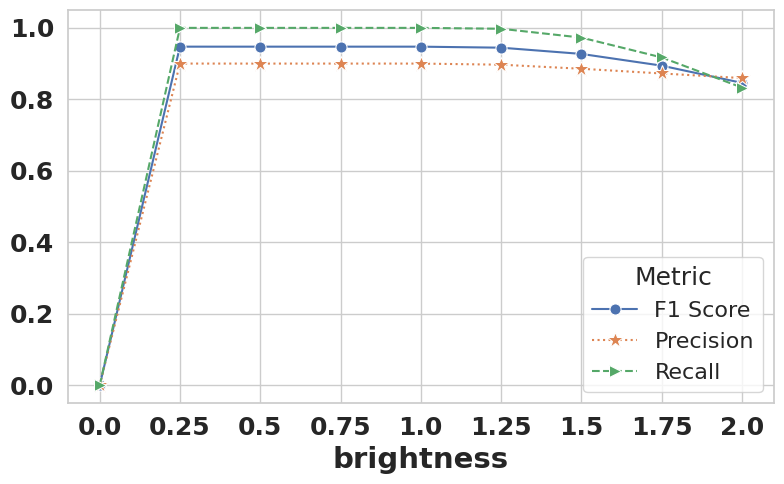

In [898]:
# for brightness, values in brightness_hamming.items():
#     print('===> Brightness:', brightness)
#     calculate_metrics(values)

Trans = 'brightness'

data = {
    Trans: [],
    'F1 Score': [],
    'Precision': [],
    'Recall': []
}
for key, values in brightness_hamming.items():
    f1, precision, recall = calculate_metrics(values)
    data[Trans].append(key)
    data['F1 Score'].append(f1)
    data['Precision'].append(precision)
    data['Recall'].append(recall)
df = pd.DataFrame(data)
df.sort_values(Trans, inplace=True)


sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")

fig = sns.lineplot(x=Trans, y='F1 Score', markersize=8, data=df, marker='o', label='F1 Score')
sns.lineplot(x=Trans, y='Precision', markersize=12, data=df, marker='*', label='Precision', linestyle=':')
sns.lineplot(x=Trans, y='Recall', markersize=8, data=df, marker='>', label='Recall', linestyle='--')

fig.set_xlabel(Trans, fontsize = 21, fontweight='bold')
fig.set_ylabel('')  # Set y-axis label as none
plt.xticks(brightness_values)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylim(-0.05, 1.05)
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
plt.legend(title='Metric', title_fontsize='18', fontsize='16')
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf')

# Contrast Robustness

In [899]:
contrast_values = list(np.linspace(0, 2, 9, endpoint=True))
contrast_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'contrast', f'{DATASET}_contrast_{int(contrast)}.csv' if 'nn' not in TARGET else f'{DATASET}_contrast_{contrast}.csv') for contrast in contrast_values],
    contrast_values,
    bin_hashes_orig,
    num_processes=9,
    pairwise=True
)

0it [00:00, ?it/s]

Precision: 0.011574584990739822
Recall: 0.003442964982241392
F1 Score: 0.005307242274284363
Precision: 0.7871642708778381
Recall: 0.842042088508606
F1 Score: 0.8136789202690125
Precision: 0.7948725819587708
Recall: 0.9390310049057007
F1 Score: 0.8609590530395508
Precision: 0.827763557434082
Recall: 0.974077045917511
F1 Score: 0.8949798345565796
Precision: 0.9001225829124451
Recall: 1.0
F1 Score: 0.9474362730979919
Precision: 0.9646328091621399
Recall: 0.9761574268341064
F1 Score: 0.9703609347343445
Precision: 0.9840160012245178
Recall: 0.9164561033248901
F1 Score: 0.9490351676940918
Precision: 0.9884268641471863
Recall: 0.769212007522583
F1 Score: 0.8651490211486816
Precision: 0.984741747379303
Recall: 0.5872638821601868
F1 Score: 0.7357521653175354


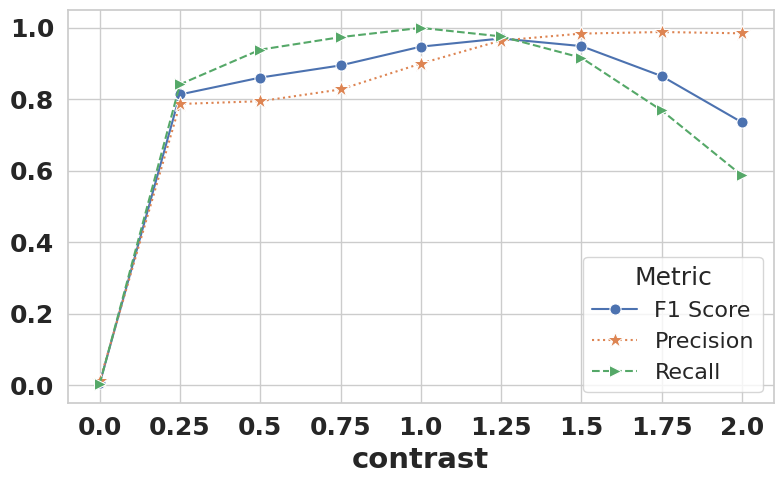

In [900]:
# for contrast, values in contrast_hamming.items():
#     print('===> Contrast:', contrast)
#     calculate_metrics(values)

Trans = 'contrast'

data = {
    Trans: [],
    'F1 Score': [],
    'Precision': [],
    'Recall': []
}
for key, values in contrast_hamming.items():
    f1, precision, recall = calculate_metrics(values)
    data[Trans].append(key)
    data['F1 Score'].append(f1)
    data['Precision'].append(precision)
    data['Recall'].append(recall)
df = pd.DataFrame(data)
df.sort_values(Trans, inplace=True)


sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")

fig = sns.lineplot(x=Trans, y='F1 Score', markersize=8, data=df, marker='o', label='F1 Score')
sns.lineplot(x=Trans, y='Precision', markersize=12, data=df, marker='*', label='Precision', linestyle=':')
sns.lineplot(x=Trans, y='Recall', markersize=8, data=df, marker='>', label='Recall', linestyle='--')

fig.set_xlabel(Trans, fontsize = 21, fontweight='bold')
fig.set_ylabel('')  # Set y-axis label as none
plt.xticks(contrast_values)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylim(-0.05, 1.05)
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
plt.legend(title='Metric', title_fontsize='18', fontsize='16')
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf')

# Saturation Robustness

In [901]:
saturation_values = list(np.linspace(0, 2, 9, endpoint=True))
saturation_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'saturation', f'{DATASET}_saturation_{int(saturation)}.csv' if 'nn' not in TARGET else f'{DATASET}_saturation_{saturation}.csv') for saturation in saturation_values],
    saturation_values,
    bin_hashes_orig,
    num_processes=9,
    pairwise=True
)

0it [00:00, ?it/s]

Precision: 0.8998263478279114
Recall: 0.9987905621528625
F1 Score: 0.9467292428016663
Precision: 0.899376630783081
Recall: 0.9995760321617126
F1 Score: 0.9468327760696411
Precision: 0.8993194699287415
Recall: 1.0
F1 Score: 0.9469912648200989
Precision: 0.8991314768791199
Recall: 1.0
F1 Score: 0.9468870162963867
Precision: 0.9001225829124451
Recall: 1.0
F1 Score: 0.9474362730979919
Precision: 0.9008662104606628
Recall: 1.0
F1 Score: 0.9478480815887451
Precision: 0.9012283086776733
Recall: 1.0
F1 Score: 0.94804847240448
Precision: 0.9012061953544617
Recall: 0.999832808971405
F1 Score: 0.9479610919952393
Precision: 0.9003561735153198
Recall: 0.9993644952774048
F1 Score: 0.9472802877426147


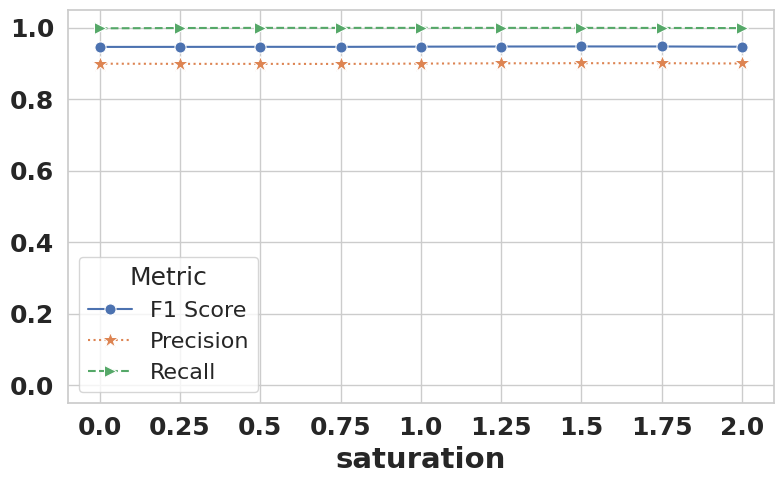

In [902]:
Trans = 'saturation'

data = {
    Trans: [],
    'F1 Score': [],
    'Precision': [],
    'Recall': []
}
for key, values in saturation_hamming.items():
    f1, precision, recall = calculate_metrics(values)
    data[Trans].append(key)
    data['F1 Score'].append(f1)
    data['Precision'].append(precision)
    data['Recall'].append(recall)
df = pd.DataFrame(data)
df.sort_values(Trans, inplace=True)


sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")

fig = sns.lineplot(x=Trans, y='F1 Score', markersize=8, data=df, marker='o', label='F1 Score')
sns.lineplot(x=Trans, y='Precision', markersize=12, data=df, marker='*', label='Precision', linestyle=':')
sns.lineplot(x=Trans, y='Recall', markersize=8, data=df, marker='>', label='Recall', linestyle='--')

fig.set_xlabel(Trans, fontsize = 21, fontweight='bold')
fig.set_ylabel('')  # Set y-axis label as none
plt.xticks(saturation_values)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylim(-0.05, 1.05)
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
plt.legend(title='Metric', title_fontsize='18', fontsize='16')
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf')

# Compression Robustness

In [903]:
compression_values = [100] + list(
    (100 - np.ceil(np.logspace(0, np.log(100) / np.log(1.5), 10, endpoint=True, base=1.5))).clip(0, 100)
)

compression_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'compression', f'{DATASET}_compression_{int(compression)}.csv' if 'nn' not in TARGET else f'{DATASET}_compression_{compression}.csv') for compression in compression_values],
    compression_values,
    bin_hashes_orig,
    num_processes=11,
    pairwise=True
)


0it [00:00, ?it/s]

Precision: 0.9134212732315063
Recall: 0.09864860773086548
F1 Score: 0.178066223859787
Precision: 0.9410294890403748
Recall: 0.07993939518928528
F1 Score: 0.1473606675863266
Precision: 0.9666890501976013
Recall: 0.19117224216461182
F1 Score: 0.3192163407802582
Precision: 0.8973925113677979
Recall: 0.639934241771698
F1 Score: 0.7471049427986145
Precision: 0.9423954486846924
Recall: 0.819428563117981
F1 Score: 0.8766207695007324
Precision: 0.9264970421791077
Recall: 0.8816916346549988
F1 Score: 0.90353924036026
Precision: 0.8990901708602905
Recall: 0.9635355472564697
F1 Score: 0.9301980137825012
Precision: 0.8885604739189148
Recall: 0.9886682033538818
F1 Score: 0.9359450340270996
Precision: 0.9054701924324036
Recall: 0.9940742254257202
F1 Score: 0.9477057456970215
Precision: 0.923463761806488
Recall: 0.9950418472290039
F1 Score: 0.9579175114631653
Precision: 0.9056128859519958
Recall: 0.9999224543571472
F1 Score: 0.9504338502883911


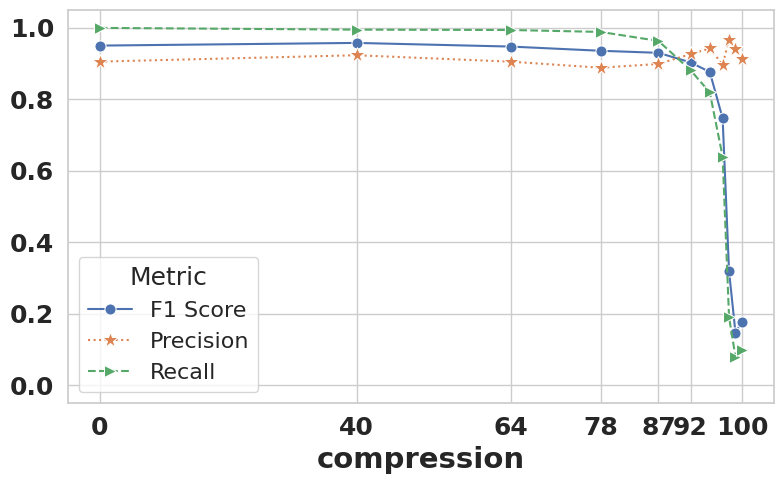

In [904]:
Trans = 'compression'

data = {
    Trans: [],
    'F1 Score': [],
    'Precision': [],
    'Recall': []
}
for key, values in compression_hamming.items():
    f1, precision, recall = calculate_metrics(values)
    data[Trans].append(key)
    data['F1 Score'].append(f1)
    data['Precision'].append(precision)
    data['Recall'].append(recall)
df = pd.DataFrame(data)
df.sort_values(Trans, inplace=True)


sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")

fig = sns.lineplot(x=Trans, y='F1 Score', markersize=8, data=df, marker='o', label='F1 Score')
sns.lineplot(x=Trans, y='Precision', markersize=12, data=df, marker='*', label='Precision', linestyle=':')
sns.lineplot(x=Trans, y='Recall', markersize=8, data=df, marker='>', label='Recall', linestyle='--')

fig.set_xlabel(Trans, fontsize = 21, fontweight='bold')
fig.set_ylabel('')  # Set y-axis label as none
plt.xticks([0, 40, 64, 78, 87, 92, 100])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylim(-0.05, 1.05)
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
plt.legend(title='Metric', title_fontsize='18', fontsize='16')
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf')

# Crop Robustness

In [905]:
crop_values = list(
    filter(
        lambda x: x != 63,  # Change this value if you specifically want to exclude a different size
        [64] + list(64 - np.append(np.logspace(0, 5, 6, base=2, endpoint=True, dtype=int), [32]))
    )
)
crop_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'crop', f'{DATASET}_crop_{int(crop)}.csv' if 'nn' not in TARGET else f'{DATASET}_crop_{crop}.csv') for crop in crop_values],
    crop_values,
    bin_hashes_orig,
    num_processes=10,
    pairwise=True
)


0it [00:00, ?it/s]

Precision: 0.9001225829124451
Recall: 1.0
F1 Score: 0.9474362730979919
Precision: 0.9031870365142822
Recall: 0.9974856376647949
F1 Score: 0.9479970932006836
Precision: 0.8976796269416809
Recall: 0.9921455383300781
F1 Score: 0.9425515532493591
Precision: 0.892177164554596
Recall: 0.9690755009651184
F1 Score: 0.9290377497673035
Precision: 0.8176924586296082
Recall: 0.5874903202056885
F1 Score: 0.6837350726127625
Precision: 0.21170933544635773
Recall: 0.03116966411471367
F1 Score: 0.05433906614780426


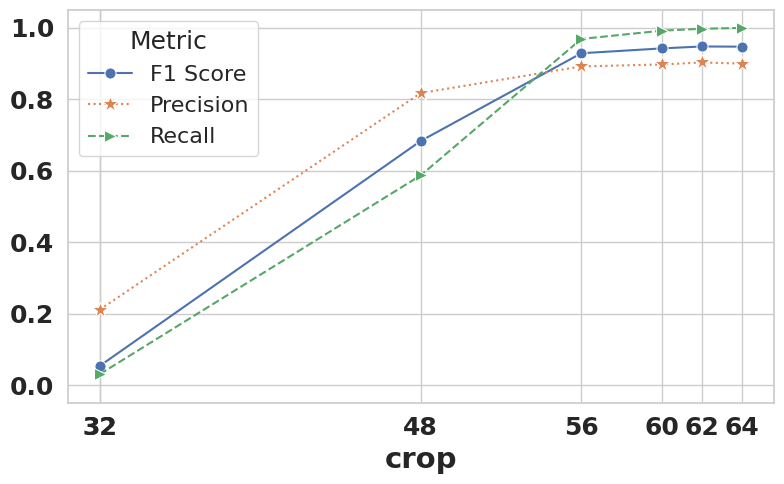

In [906]:
Trans = 'crop'

data = {
    Trans: [],
    'F1 Score': [],
    'Precision': [],
    'Recall': []
}
for key, values in crop_hamming.items():
    f1, precision, recall = calculate_metrics(values)
    data[Trans].append(key)
    data['F1 Score'].append(f1)
    data['Precision'].append(precision)
    data['Recall'].append(recall)
df = pd.DataFrame(data)
df.sort_values(Trans, inplace=True)


sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")

fig = sns.lineplot(x=Trans, y='F1 Score', markersize=8, data=df, marker='o', label='F1 Score')
sns.lineplot(x=Trans, y='Precision', markersize=12, data=df, marker='*', label='Precision', linestyle=':')
sns.lineplot(x=Trans, y='Recall', markersize=8, data=df, marker='>', label='Recall', linestyle='--')

fig.set_xlabel(Trans, fontsize = 21, fontweight='bold')
fig.set_ylabel('')  # Set y-axis label as none
plt.xticks(crop_values)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylim(-0.05, 1.05)
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
plt.legend(title='Metric', title_fontsize='18', fontsize='16')
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf')

# Horizontal Flipping Robustness

In [907]:
hflip_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'hflip', f'{DATASET}_hflip.csv')],
    [0],
    bin_hashes_orig,
    num_processes=1,
    pairwise=True
)

0it [00:00, ?it/s]

In [908]:
for key, values in hflip_hamming.items():
    print('===> H Flip:', key)
    calculate_metrics(values)

===> H Flip: 0
Precision: 0.7308201193809509
Recall: 0.3374781012535095
F1 Score: 0.4617358148097992


# Vertical Flipping Robustness

In [909]:
vflip_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'vflip', f'{DATASET}_vflip.csv')],
    [0],
    bin_hashes_orig,
    num_processes=1,
    pairwise=True
)

0it [00:00, ?it/s]

In [910]:
for key, values in vflip_hamming.items():
    print('===> V Flip:', key)
    calculate_metrics(values)

===> V Flip: 0
Precision: 0.4161134958267212
Recall: 0.07887950539588928
F1 Score: 0.13261935114860535


# Downsizing Robustness

In [911]:
downsizing_values = list(
    filter(
        lambda x: x != 63,  # Ensure consistency in what's being excluded
        [64] + list(64 - np.append(np.logspace(0, 5, 6, base=2, endpoint=True, dtype=int), [32]))
    )
)
downsizing_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'downsizing', f'{DATASET}_downsizing_{size}.csv') for size in downsizing_values],
    downsizing_values,
    bin_hashes_orig,
    num_processes=9,
    pairwise=True
)

0it [00:00, ?it/s]

Precision: 0.9001225829124451
Recall: 1.0
F1 Score: 0.9474362730979919
Precision: 0.9216253757476807
Recall: 0.9935189485549927
F1 Score: 0.9562227129936218
Precision: 0.9722027778625488
Recall: 0.5819426774978638
F1 Score: 0.72807377576828
Precision: 0.9453880786895752
Recall: 0.022761428728699684
F1 Score: 0.04445260390639305
Precision: 0.24064913392066956
Recall: 0.0009440021822229028
F1 Score: 0.0018806271255016327
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


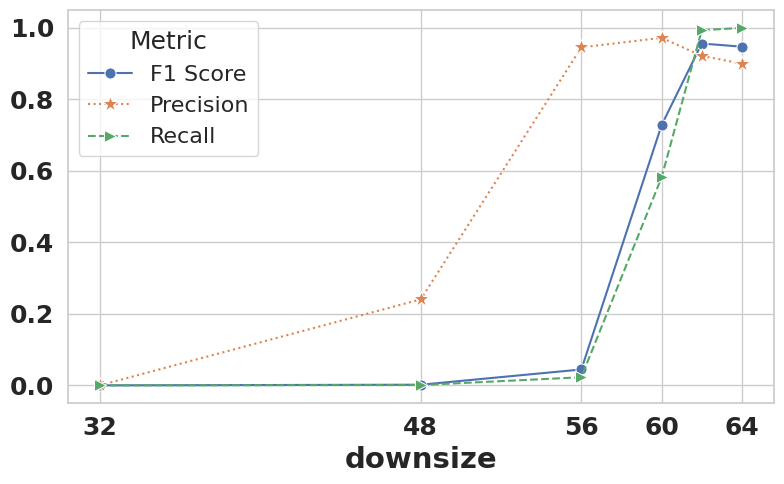

In [912]:
Trans = 'downsize'

data = {
    Trans: [],
    'F1 Score': [],
    'Precision': [],
    'Recall': []
}
for key, values in downsizing_hamming.items():
    f1, precision, recall = calculate_metrics(values)
    data[Trans].append(key)
    data['F1 Score'].append(f1)
    data['Precision'].append(precision)
    data['Recall'].append(recall)
df = pd.DataFrame(data)
df.sort_values(Trans, inplace=True)


sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")

fig = sns.lineplot(x=Trans, y='F1 Score', markersize=8, data=df, marker='o', label='F1 Score')
sns.lineplot(x=Trans, y='Precision', markersize=12, data=df, marker='*', label='Precision', linestyle=':')
sns.lineplot(x=Trans, y='Recall', markersize=8, data=df, marker='>', label='Recall', linestyle='--')

fig.set_xlabel(Trans, fontsize = 21, fontweight='bold')
fig.set_ylabel('')  # Set y-axis label as none
plt.xticks([64, 60, 56, 48, 32])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylim(-0.05, 1.05)
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
plt.legend(title='Metric', title_fontsize='18', fontsize='16')
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf')